<a href="https://colab.research.google.com/github/AndreyKuratov/project_mldm_21/blob/main/MLDM_stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as signal
import os
from tqdm import tqdm

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

import librosa as lb 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from skimage.transform import resize
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

import torchvision.models as models
import torch

import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader

In [3]:
import torchvision.models as models
import torch

import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import label_ranking_average_precision_score

def crtclass(mdTp,num_classes=24):
  if mdTp == 'Res18':
    modelF = models.resnet18()
    modelF.fc = nn.Linear(512, num_classes)
  elif mdTp == 'Res34':
    modelF = models.resnet34()
    modelF.fc = nn.Linear(512, num_classes)
  elif mdTp == 'Res50':
    modelF = models.resnet50()
    modelF.fc = nn.Linear(2048, num_classes)
  elif mdTp == 'Alex':
    modelF = models.alexnet()
    modelF.classifier[6] = nn.Linear(4096,num_classes)
  elif mdTp == 'VGG':
    modelF = models.vgg16()
    modelF.classifier[6] = nn.Linear(4096,num_classes)
  elif mdTp == 'Squeez':
    modelF = models.squeezenet1_0()
    modelF.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
  elif mdTp == 'Modile_v3':
    modelF = models.mobilenet_v3_small()
    modelF.classifier[0] = nn.Linear(in_features=576, out_features=4096, bias=True)
    modelF.classifier[3] = nn.Linear(4096,num_classes,bias=True)
  else:
    assert False, 'no model'
  return modelF

def train_step(model,idata,ilabels,criterion,optimizer,DEVICE):
    model.zero_grad()
    idata = idata.type(torch.FloatTensor).to(DEVICE)
    ilabels = ilabels.type(torch.FloatTensor).to(DEVICE)
    train_output = model(idata)
    #optimizer.zero_grad()
    loss = criterion(train_output, ilabels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test_acc(criterion, test_loader,model,DEVICE):
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))

    model.eval()
    acc_array=[]
    labels_output = []
    labels_true = []
    losses = []
    with torch.no_grad():
      for i_test_data, i_test_labels in test_loader:
            i_test_data = i_test_data.type(torch.FloatTensor).to(DEVICE)
            i_test_labels = i_test_labels.type(torch.FloatTensor).to(DEVICE)
            test_output = model(i_test_data)
            losses.append(criterion(test_output, i_test_labels).item())
            i_test_labels = i_test_labels.cpu().detach().numpy()
            test_output = test_output.cpu().detach().numpy()
            

            labels_true+=list(i_test_labels)
            labels_output+=list(test_output)
    labels_true = np.array(labels_true)
    labels_output = sigmoid(np.array(labels_output))
    try:
      score = label_ranking_average_precision_score(labels_true, labels_output)
    except:
      score = 0.0

    return score, np.mean(losses)

class simpleDataset(Dataset):
    def __init__(self, numpy_dataset, numpy_labels, transform=None, target_transform=None):
        self.dataset = numpy_dataset
        self.labels = numpy_labels
        self.length = len(numpy_labels)
        self.target_transform = target_transform
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.transform != None:
          data = self.transform(self.dataset[idx])
        else:
          data = self.dataset[idx]
        if self.target_transform != None:
          target = self.target_transform(self.labels[idx])
        else:
          target = self.labels[idx]
        return data, target

In [141]:
TEST_SIZE = 0.1
BATCH_SIZE = 8

LR = 1e-3
LR_red = 1e-2

MOMENTUM = 0.9

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH_NUM = 100

update_best_models_Flag = True
print(DEVICE)

cuda


In [101]:
PATH_TO_DIR = '/content/drive/MyDrive/mldm21_project/'
PATH_TO_SAVE = '/content/drive/MyDrive/mldm21_project/'
PATH_TO_DIR_TRAIN = '/content/drive/MyDrive/MLDM_proj/prepared_arrays/'

data_tr = np.load(PATH_TO_DIR + 'pure_train_tp_SbG_3.npz')
# data_tr1 = np.load(PATH_TO_SAVE + 'sr_48e3_nfft_2e11_hlop_2e9_pict_256x512_u8_tp.npz', allow_pickle=True)
data_ts = np.load(PATH_TO_SAVE + 'pure_test.npz')
# data_mts = np.load(PATH_TO_SAVE + 'MAJOR_test.npz')

In [102]:
train_data = data_tr['data']
train_labels = data_tr['labels']
test_data = data_ts['data']
test_labels = data_ts['labels']

In [103]:
train_dataset = simpleDataset(train_data, train_labels)
test_dataset = simpleDataset(test_data, test_labels)

In [104]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Stack models

In [9]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [140]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        set_parameter_requires_grad(self.modelA)
        self.modelB = modelB
        set_parameter_requires_grad(self.modelB)
        # self.modelC = modelC
        # set_parameter_requires_grad(self.modelC)
        self.num_ftrs = modelA.fc.in_features + modelB.fc.in_features #+ modelC.fc.in_features



        # self.linear0 = nn.Linear(modelA.fc.in_features, modelB.fc.in_features)

        modelA.fc = Identity()
        modelB.fc = Identity()
        # modelC.fc = Identity()
        self.linear1 = nn.Linear(self.num_ftrs, 2000)
        self.bnorm1 =  nn.BatchNorm1d(2000)
        self.relu1 = nn.ReLU()
        # self.linear2 = nn.Linear(3000, 1000)
        # self.bnorm2 =  nn.BatchNorm1d(1000)
        # self.relu2 = nn.ReLU()
        self.classifier = nn.Linear(2000, 24)
        
    def forward(self, x):
        x1 = self.modelA(x)
        # x1 = self.linear0(x1)
        x2 = self.modelB(x)
        # x3 = self.modelC(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.linear1(x)
        x = self.bnorm1(x)
        x = self.relu1(x)
        # x = self.linear2(x)
        # x = self.bnorm2(x)
        # x = self.relu2(x)
        x = self.classifier(x)
        return x

In [142]:
link_to_model1 = '/content/drive/MyDrive/mldm21_project/model_Res50pt_epoch_100_level_tpfpshiht4k_pretraind'
link_to_model2 = '/content/drive/MyDrive/mldm21_project/model_Res18_augTotal'
link_to_model3 = '/content/drive/MyDrive/mldm21_project/model_Res18_epoch_20_level_1plusLR1e2'

# model_1 = crtclass('Res50')
# model_1.load_state_dict(torch.load(link_to_model1))

model_2 = crtclass('Res18')
model_2.load_state_dict(torch.load(link_to_model2))

model_3 = crtclass('Res18')
model_3.load_state_dict(torch.load(link_to_model3))

<All keys matched successfully>

In [143]:
model = MyEnsemble(model_2, model_3)

In [144]:
params_to_update = []
for name,param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

In [134]:
len(params_to_update)

6

In [145]:
model = model.to(DEVICE)
best_model = model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params_to_update, lr=LR)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3,  verbose=True)



models_arr = [model]

criterion_arr = [criterion]
optimizer_arr = [optimizer]
scheduler_arr = [scheduler]

num_models = len(models_arr)

In [146]:
best_models_arr = [best_model]
ModelNames = ['stack']

In [147]:
generation = 'stack_model_2models'
PATH = '/content/drive/MyDrive/MLDM_proj/'

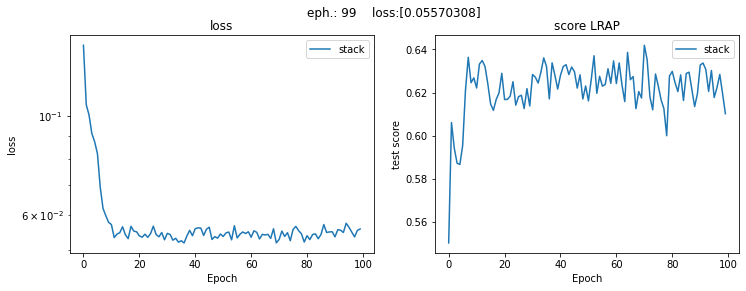

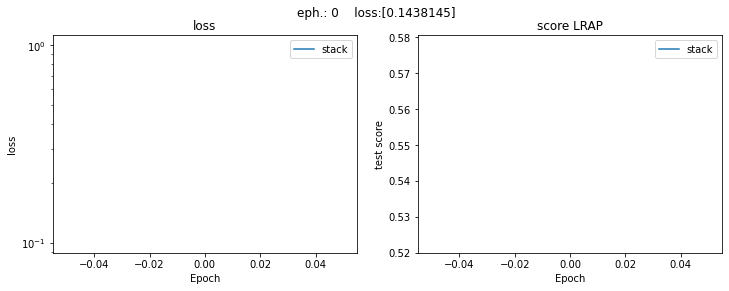

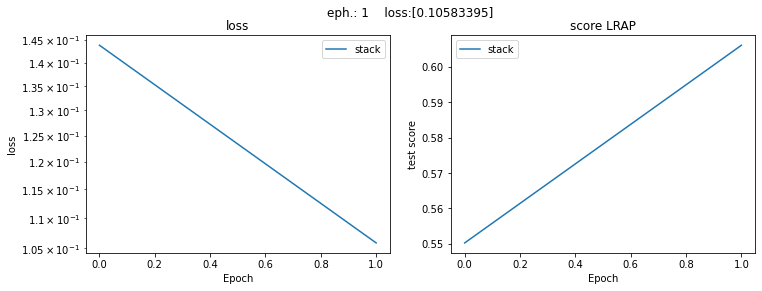

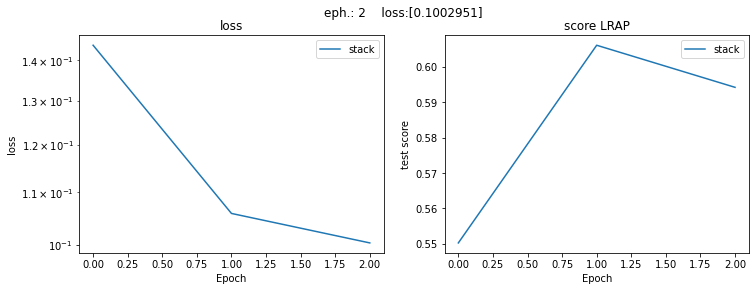

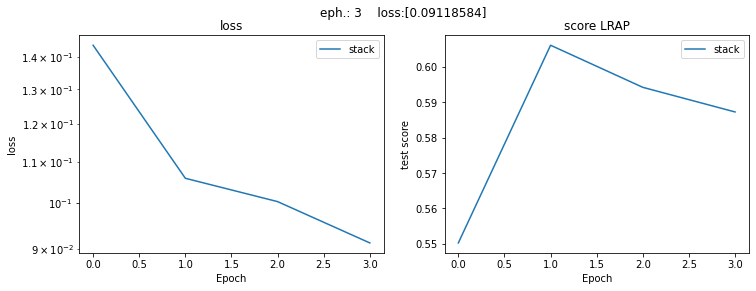

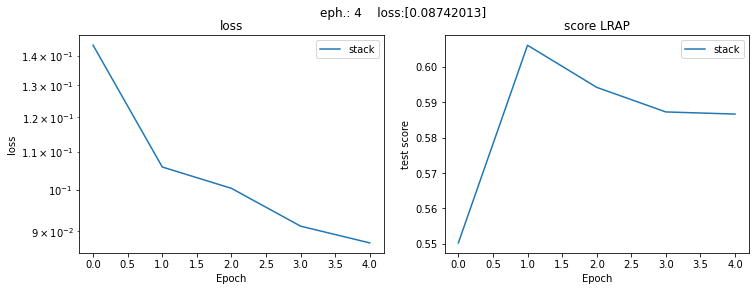

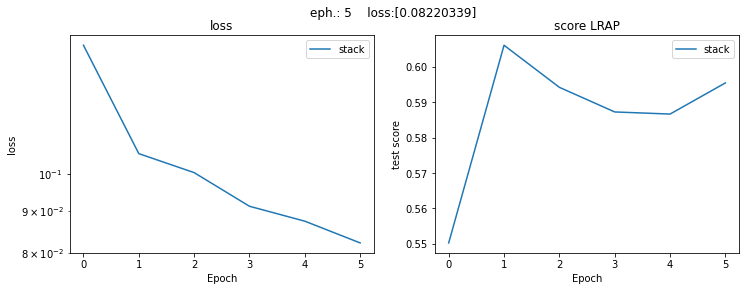

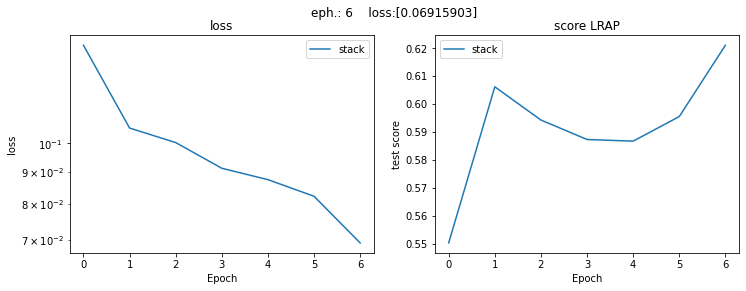

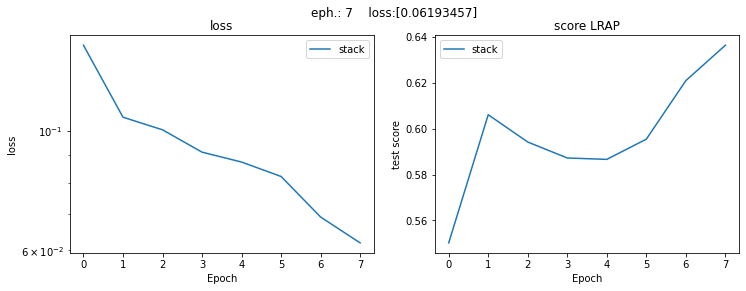

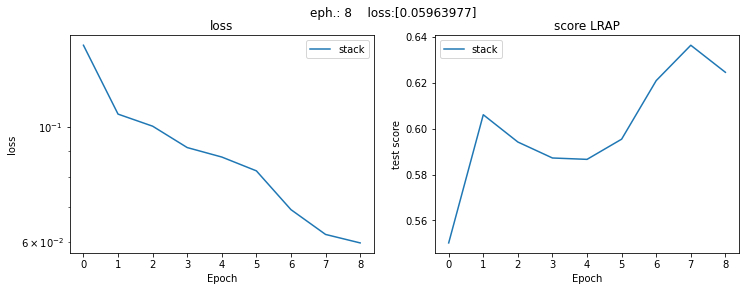

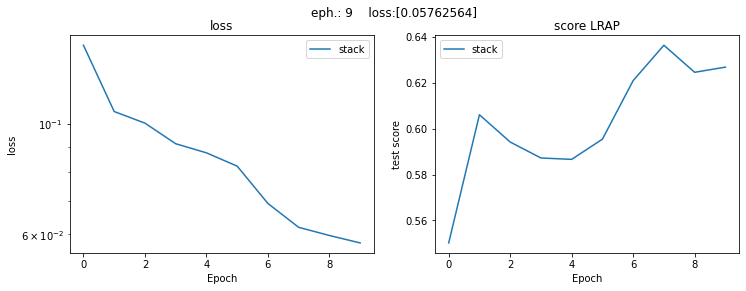

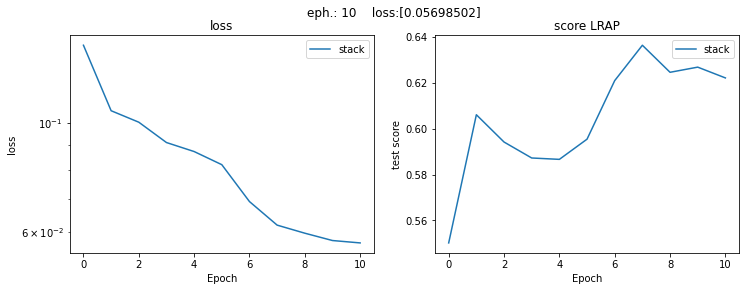

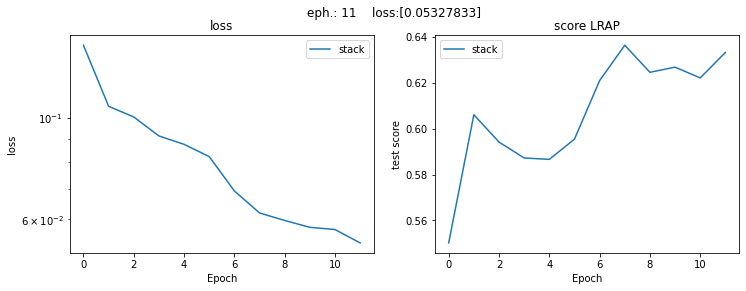

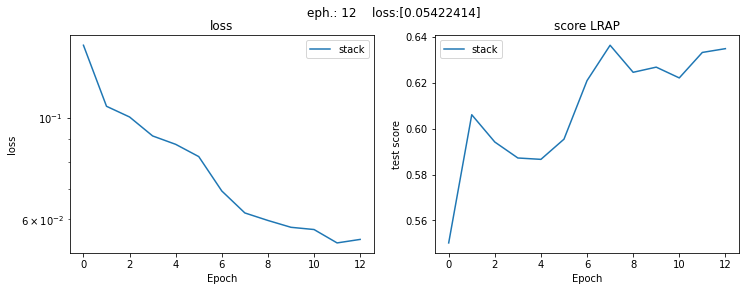

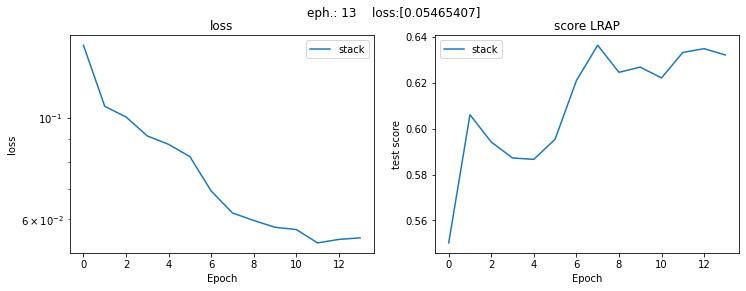

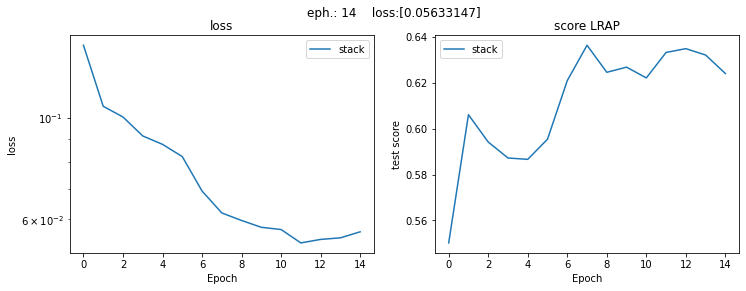

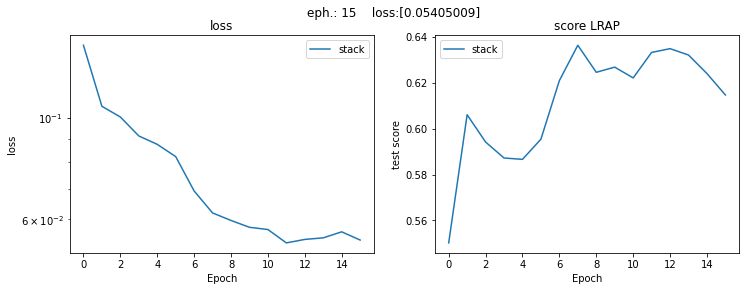

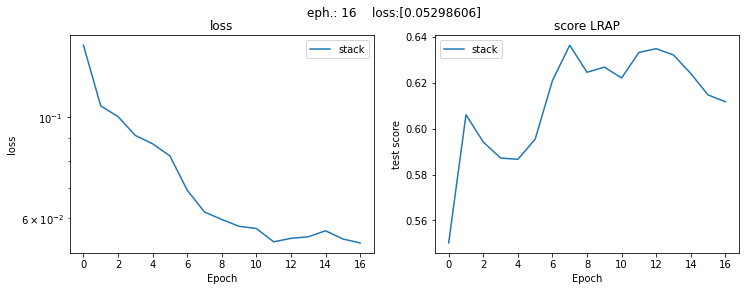

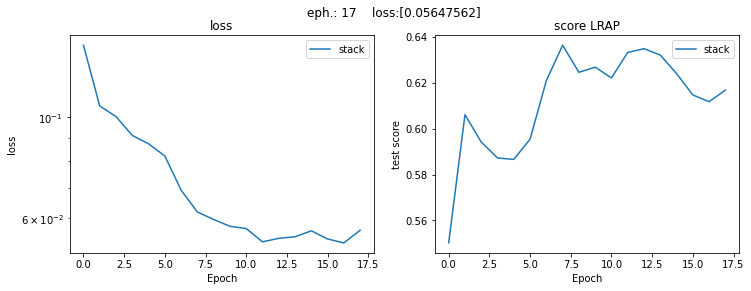

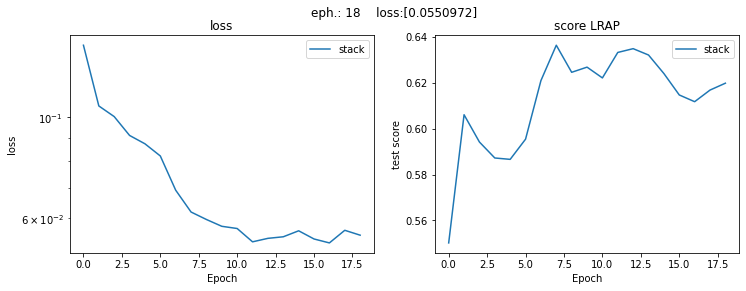

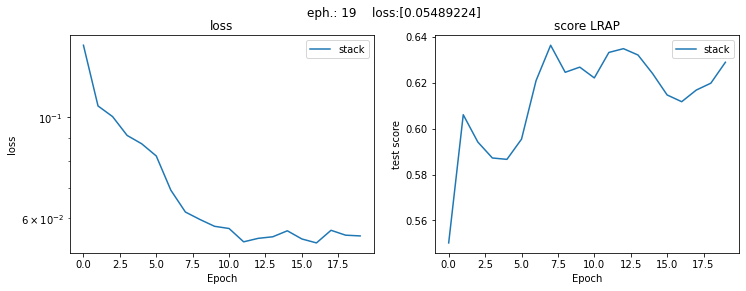

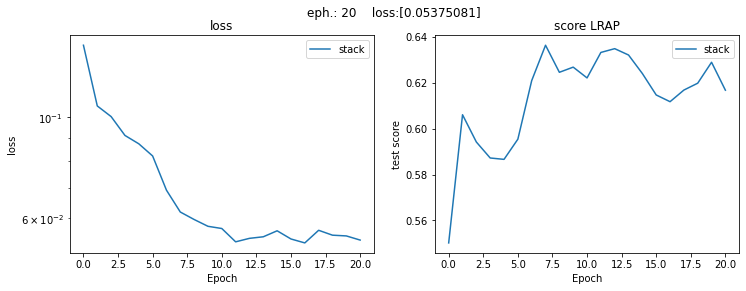

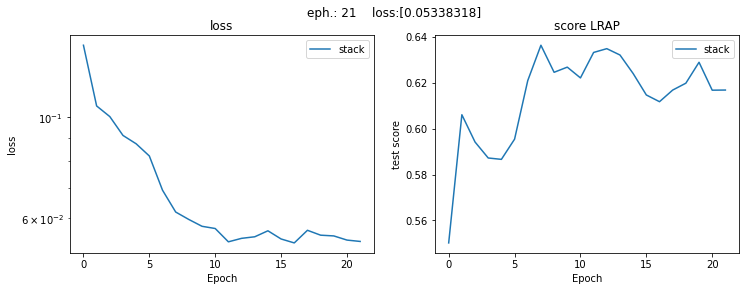

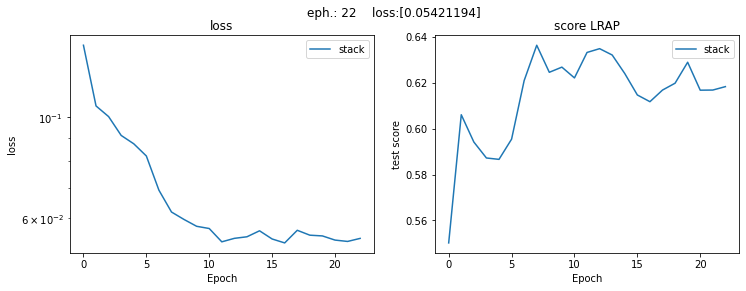

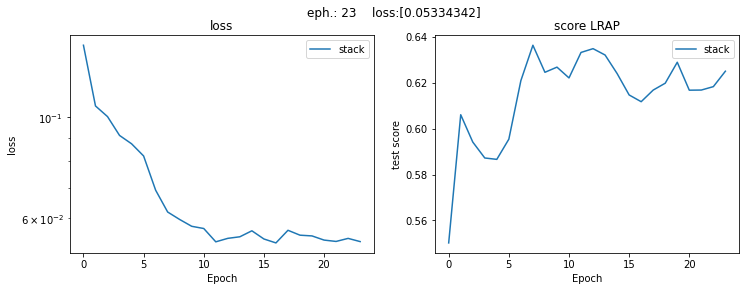

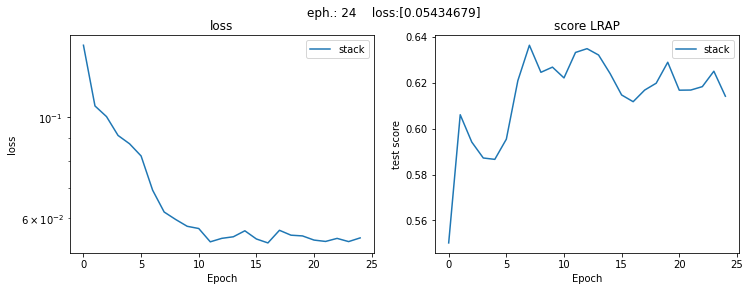

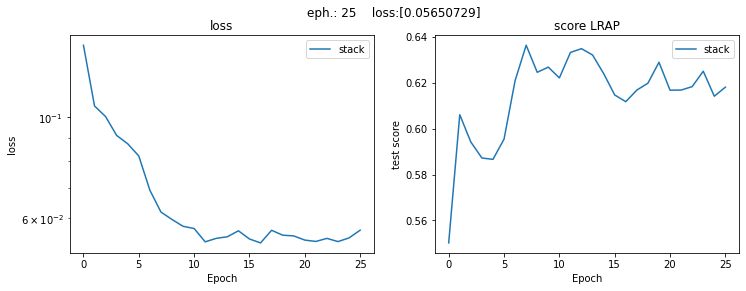

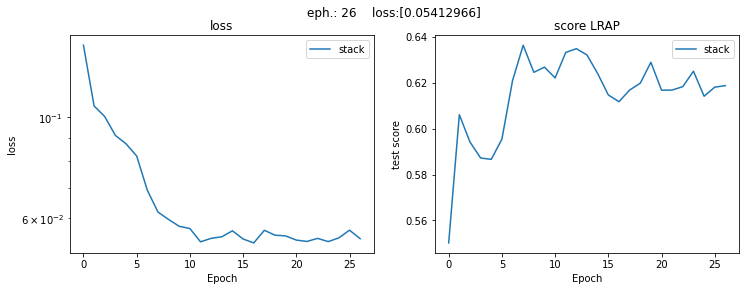

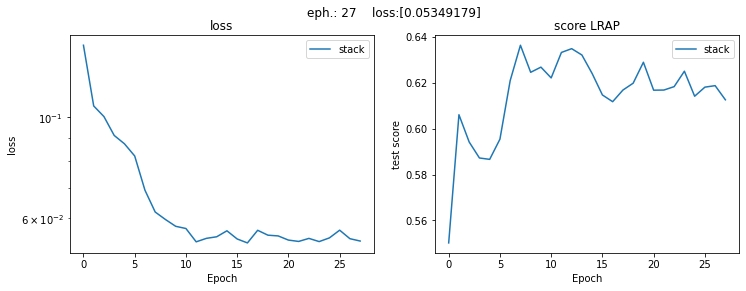

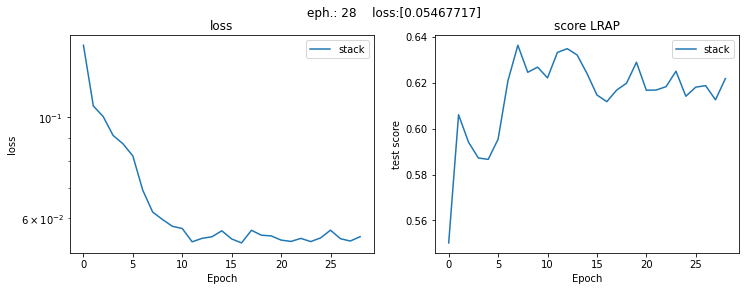

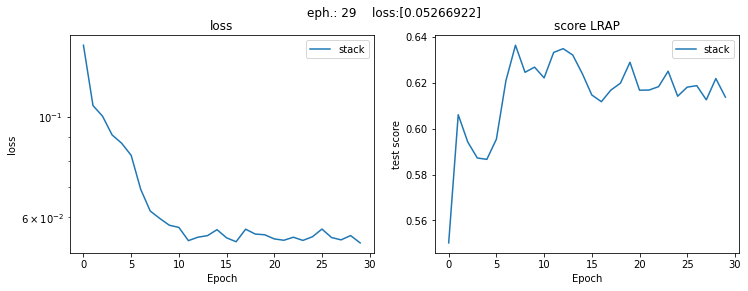

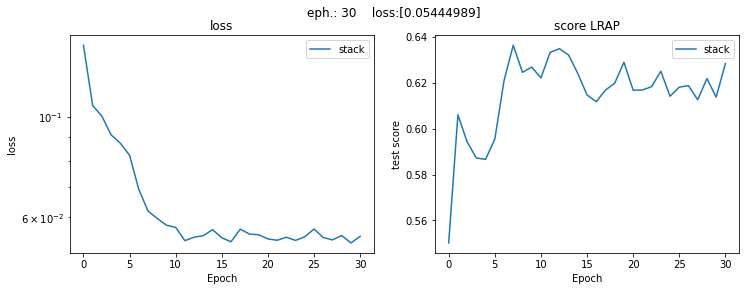

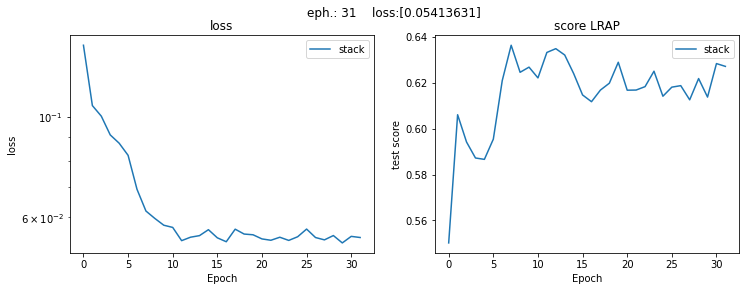

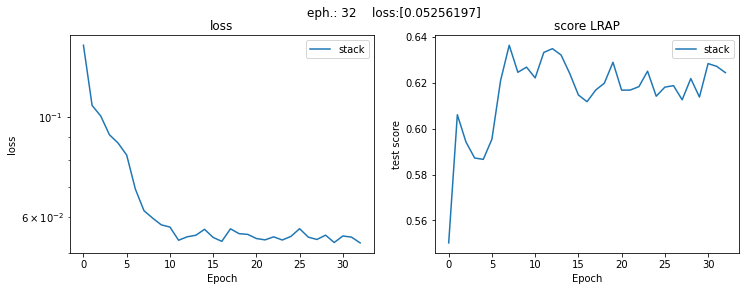

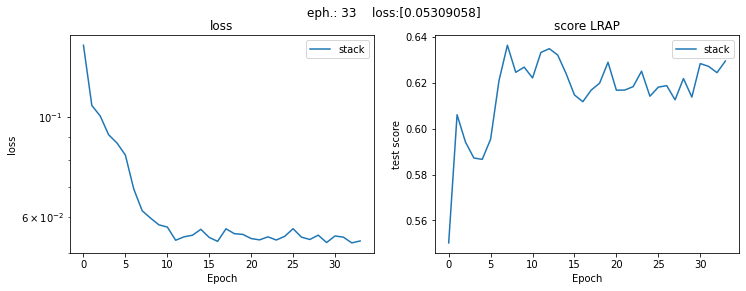

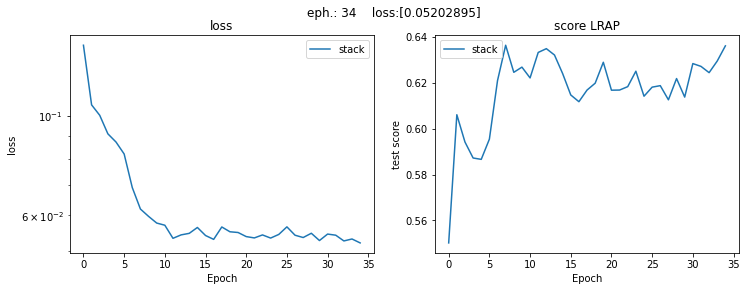

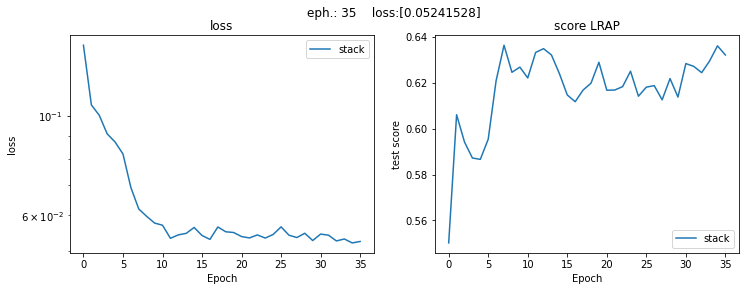

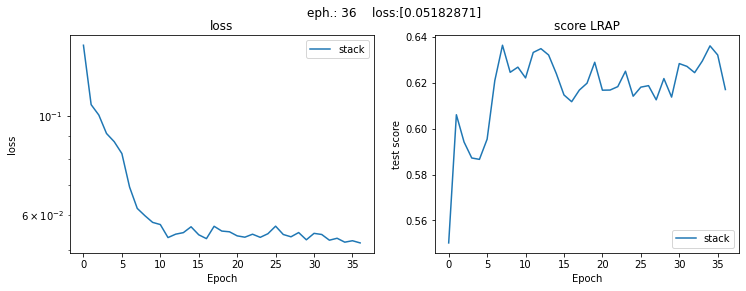

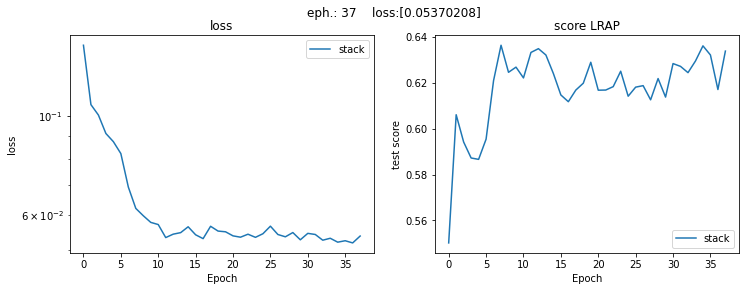

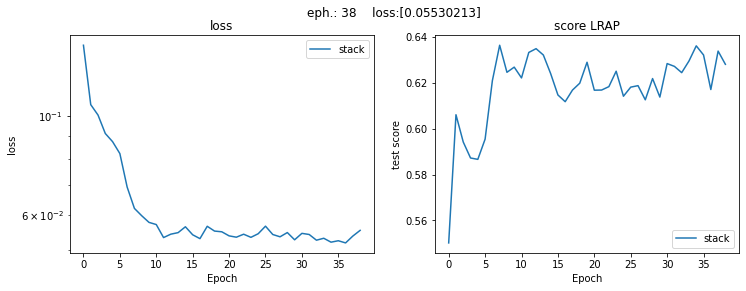

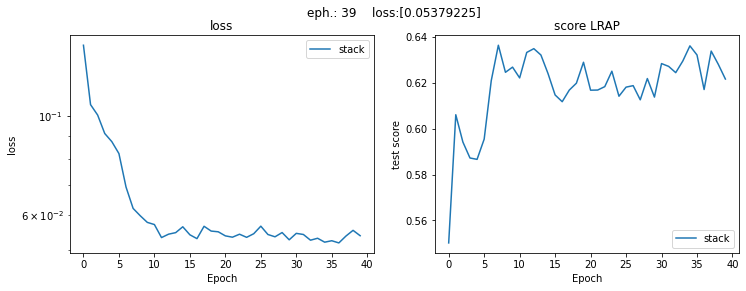

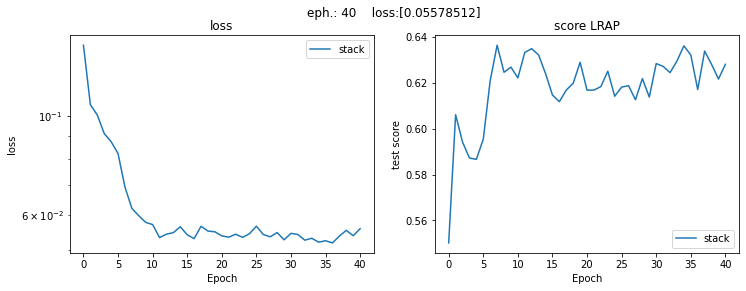

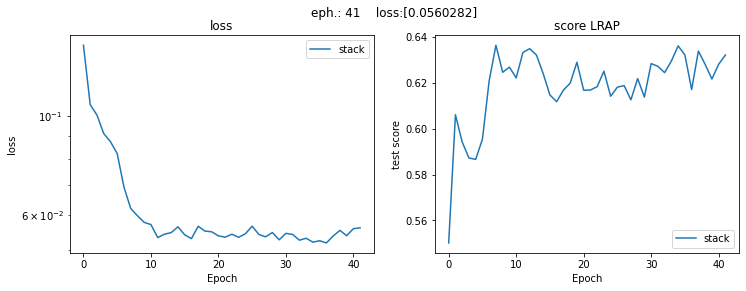

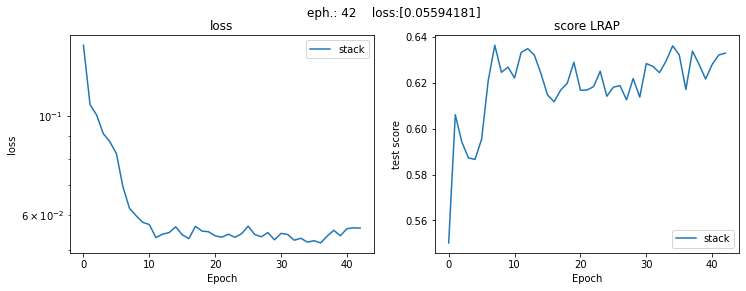

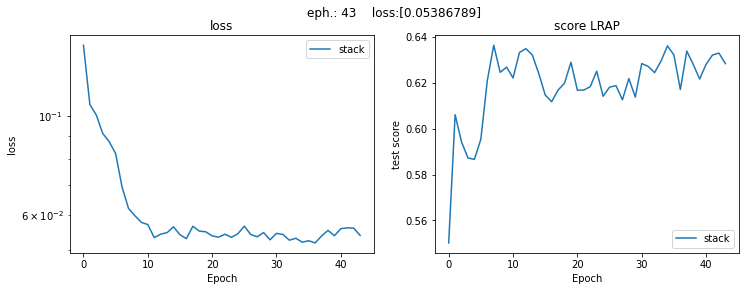

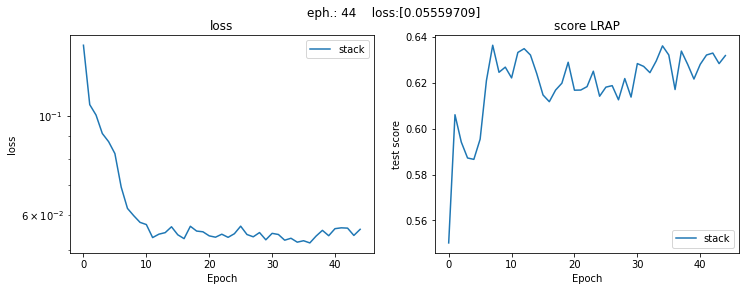

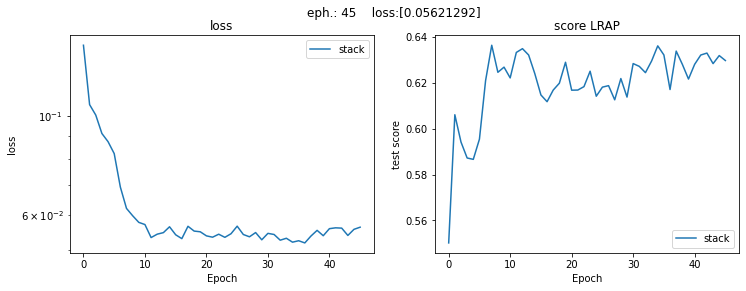

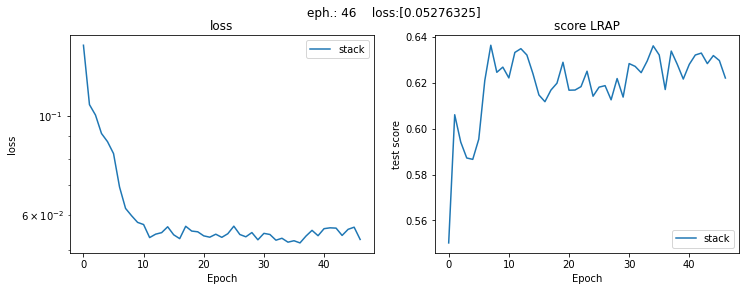

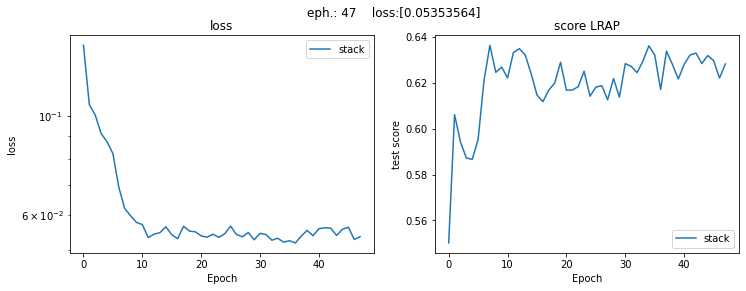

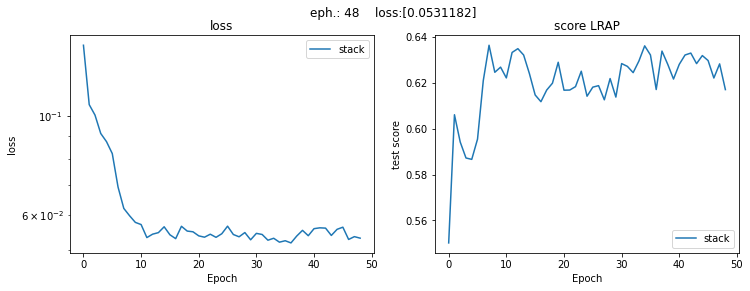

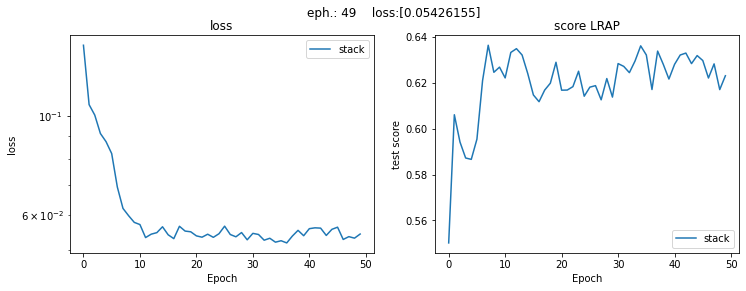

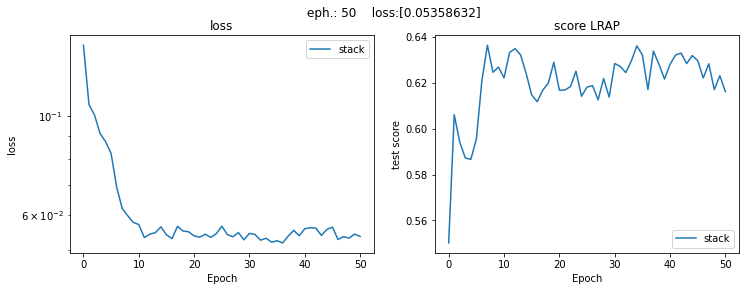

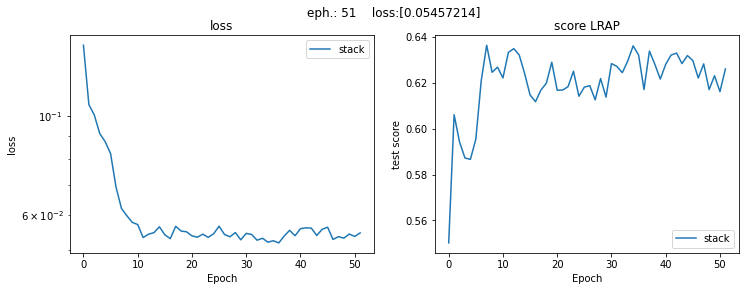

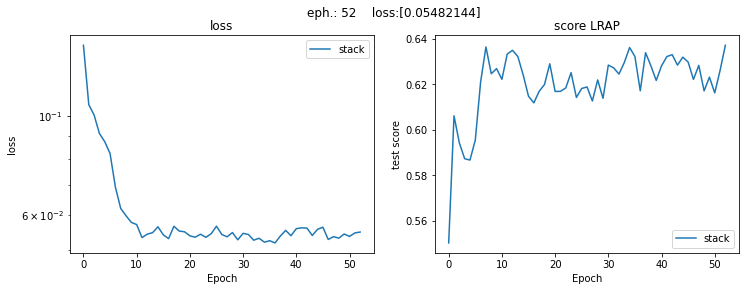

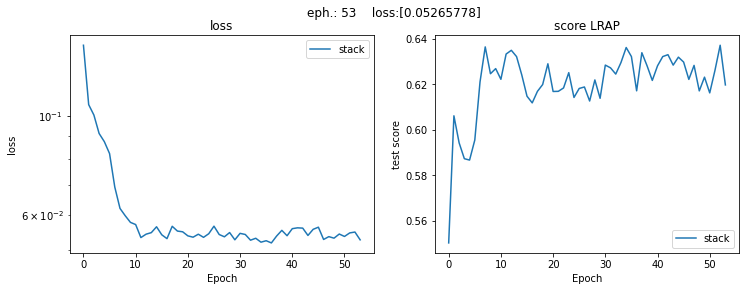

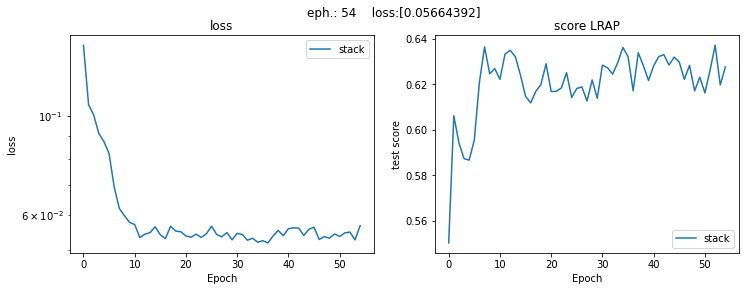

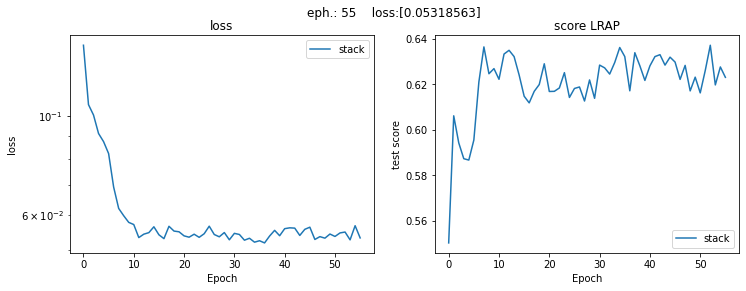

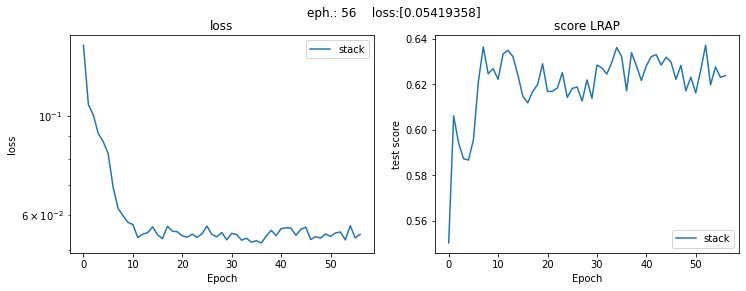

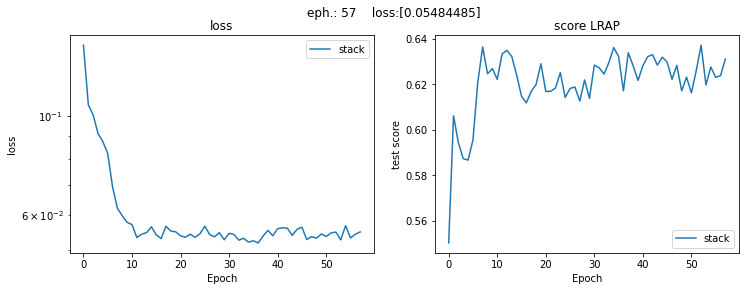

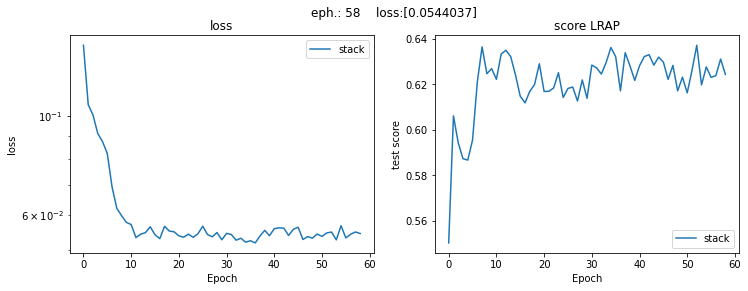

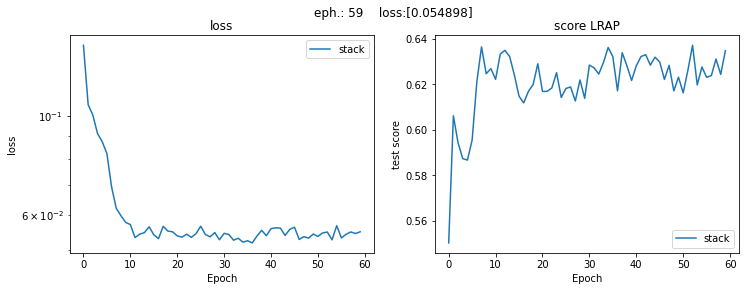

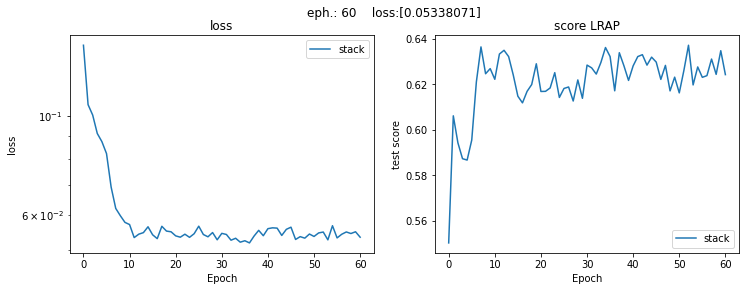

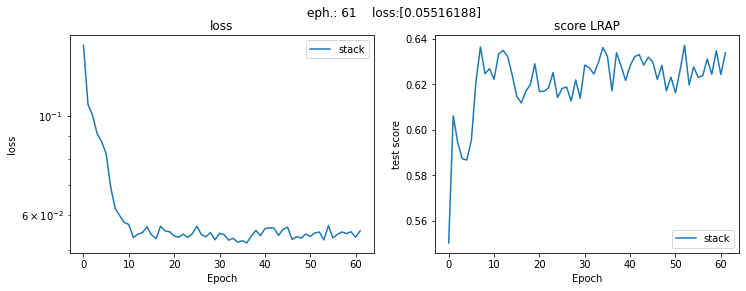

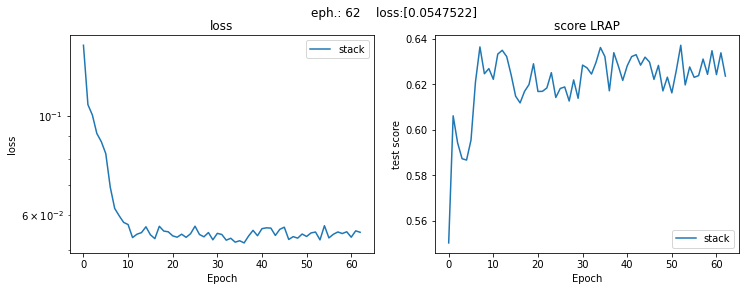

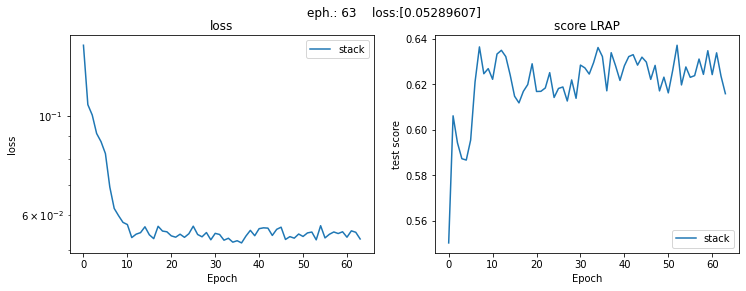

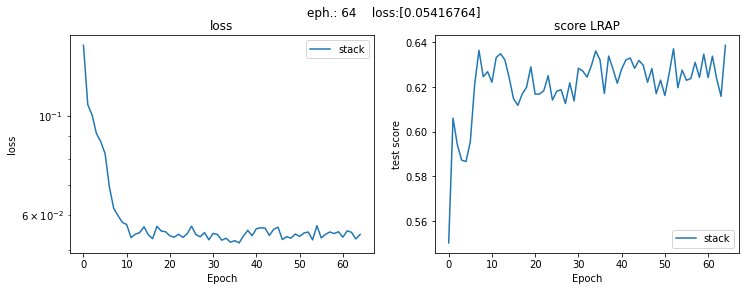

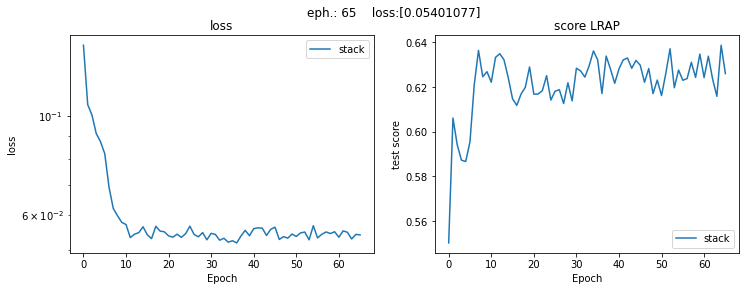

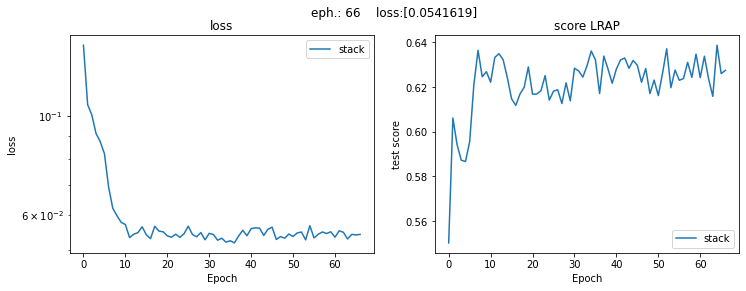

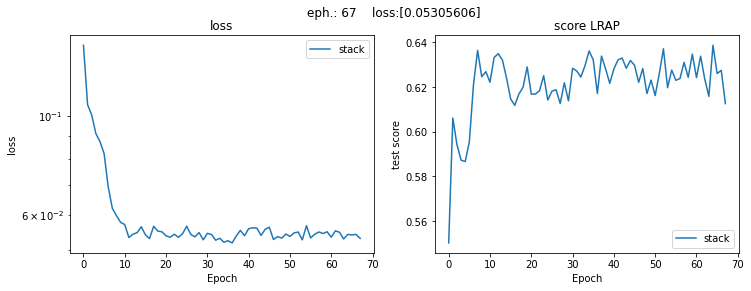

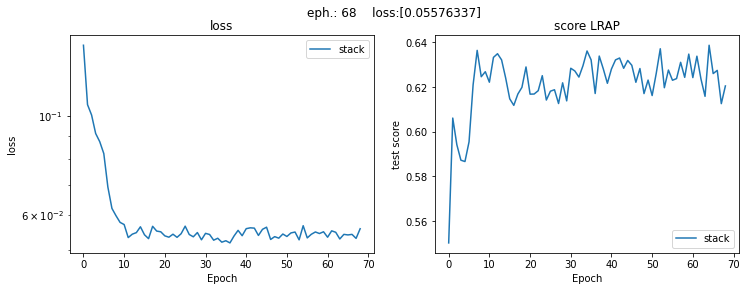

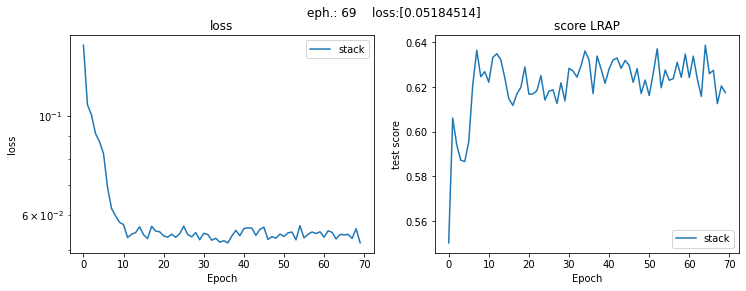

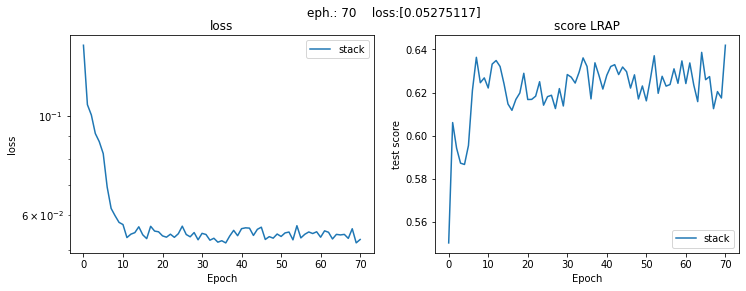

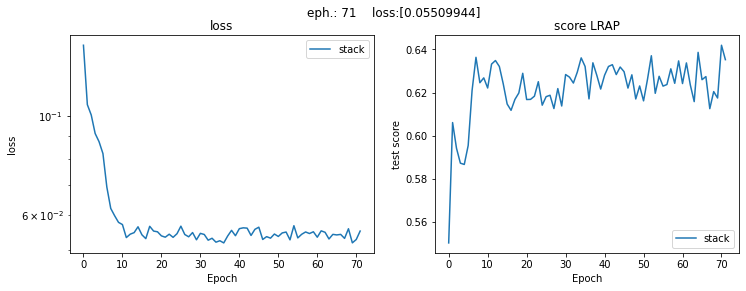

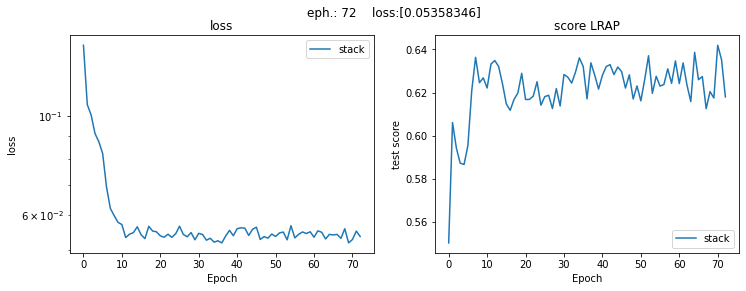

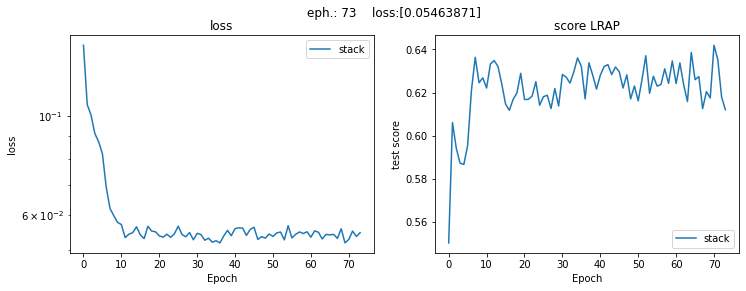

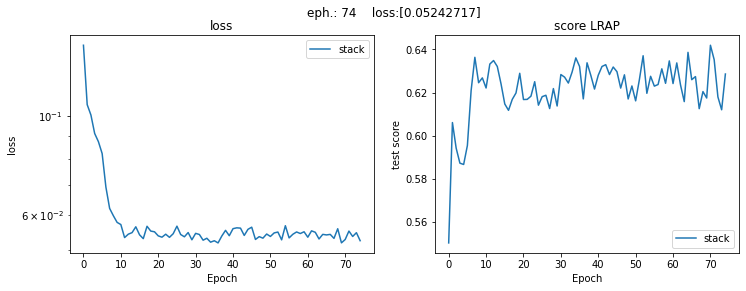

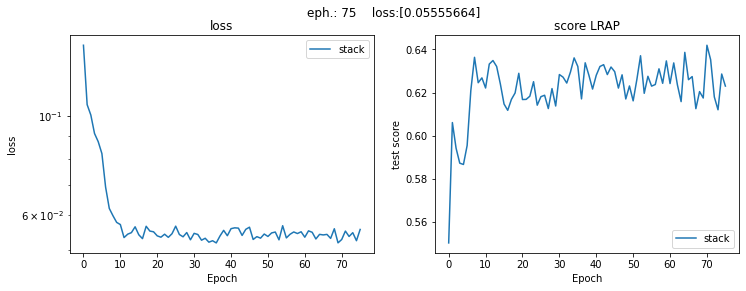

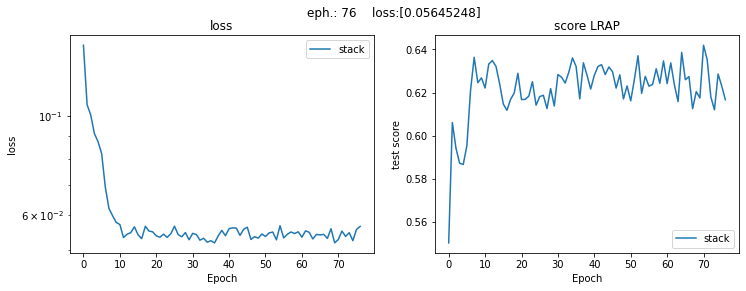

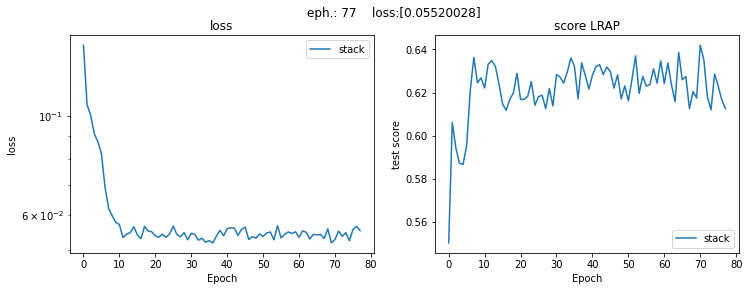

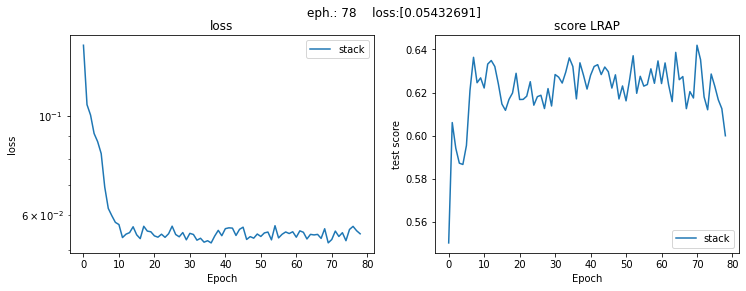

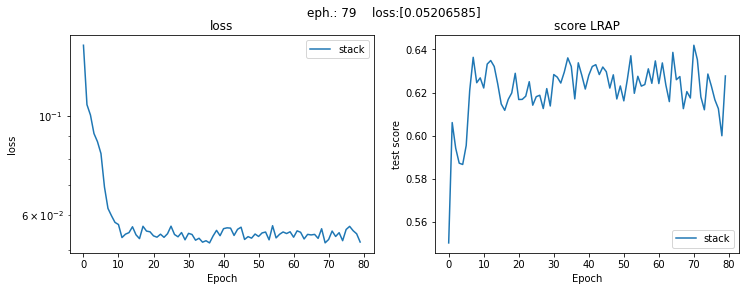

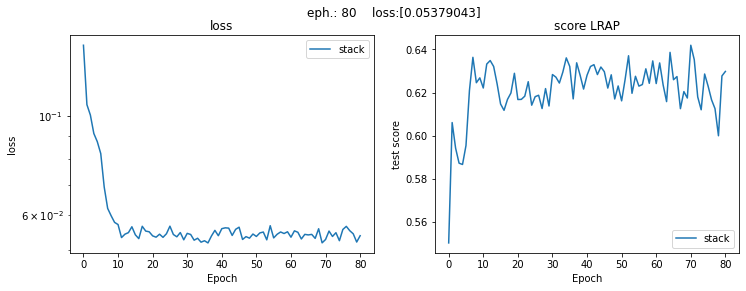

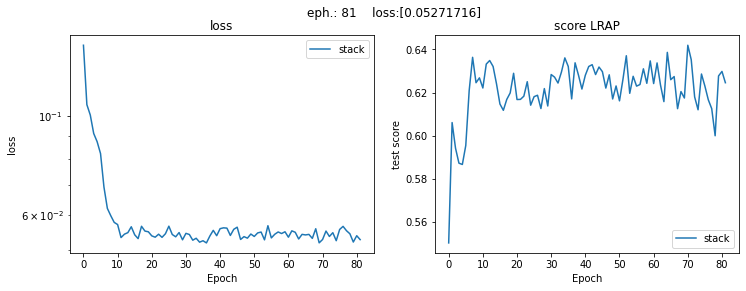

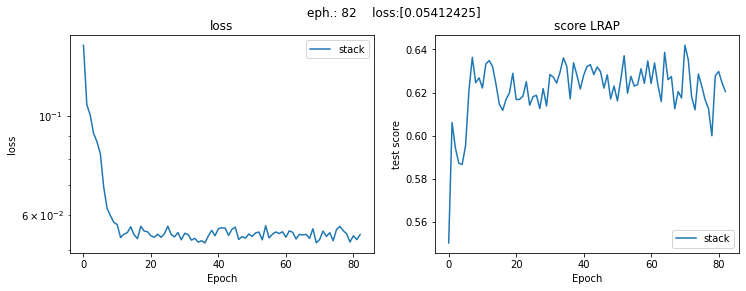

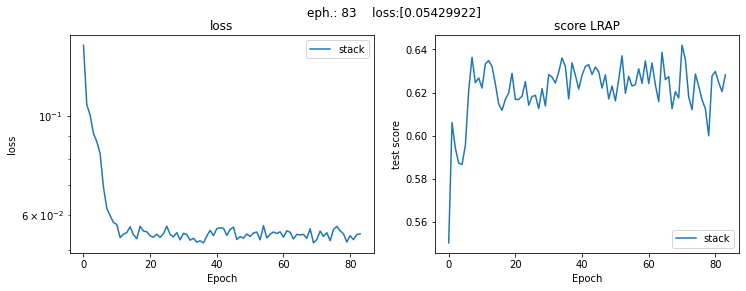

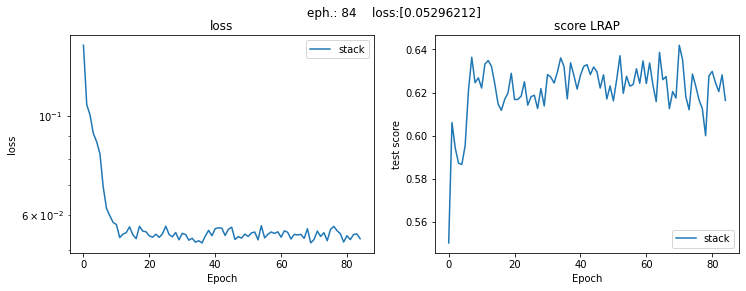

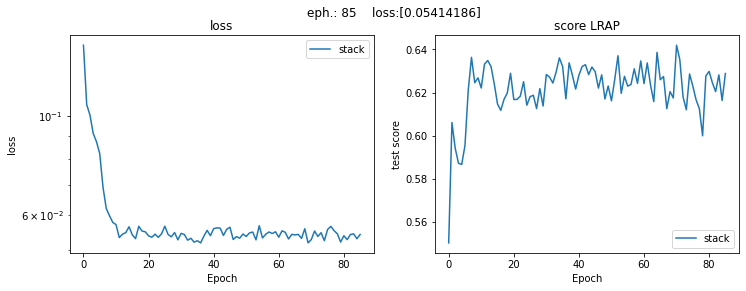

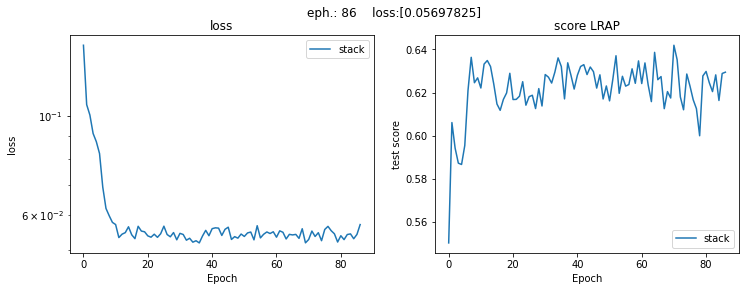

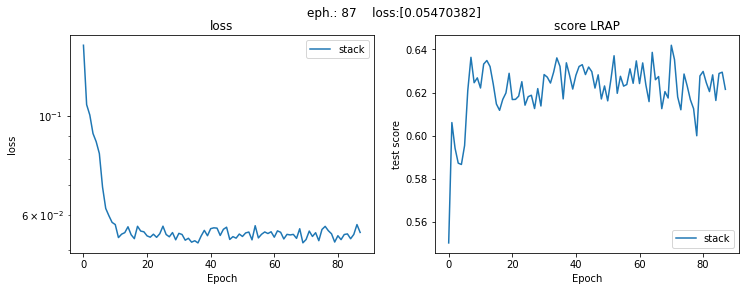

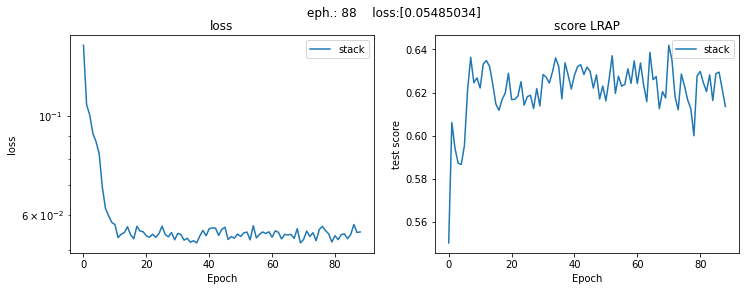

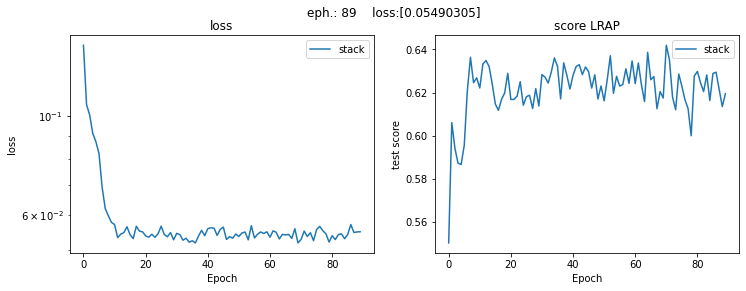

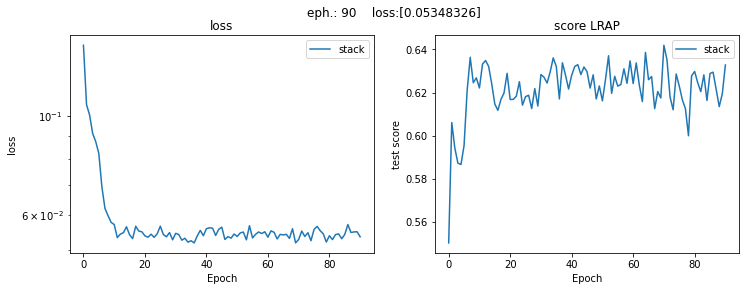

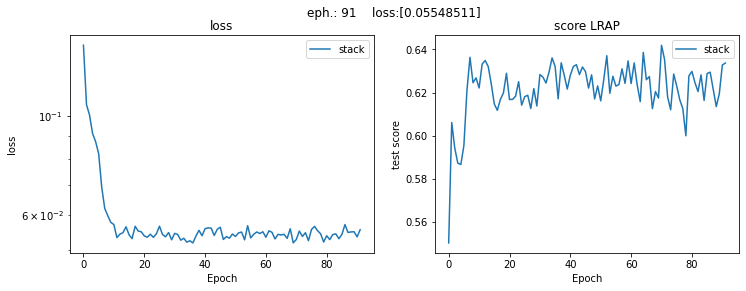

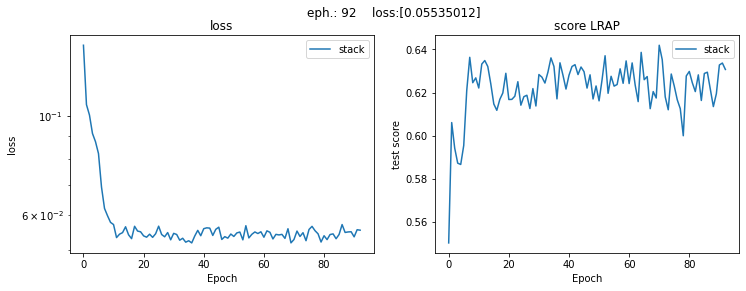

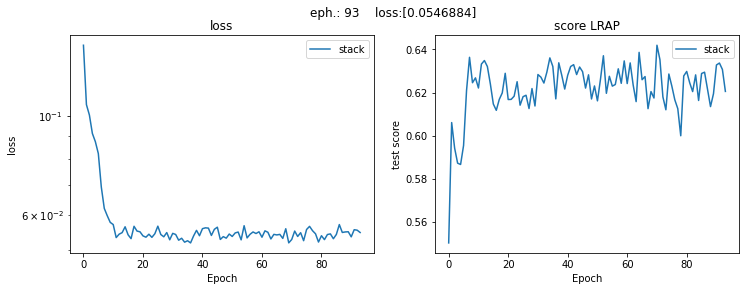

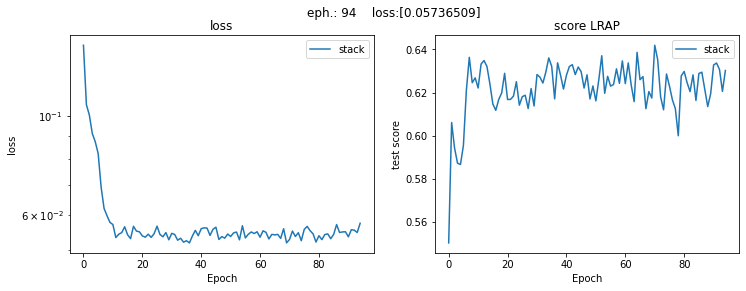

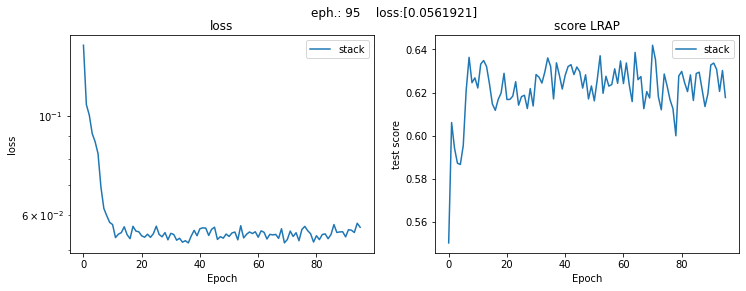

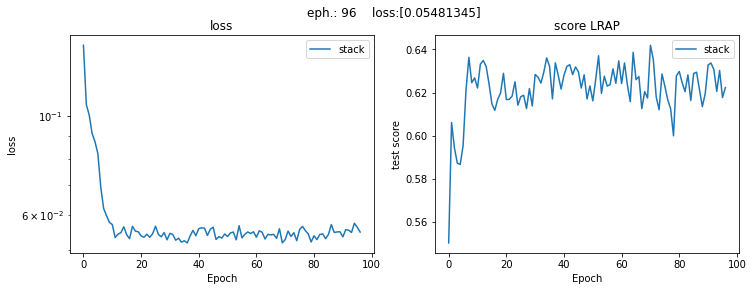

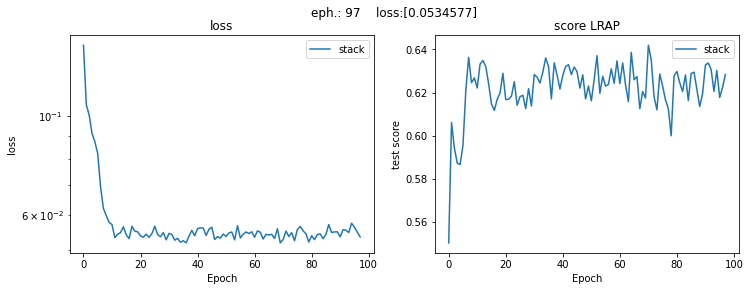

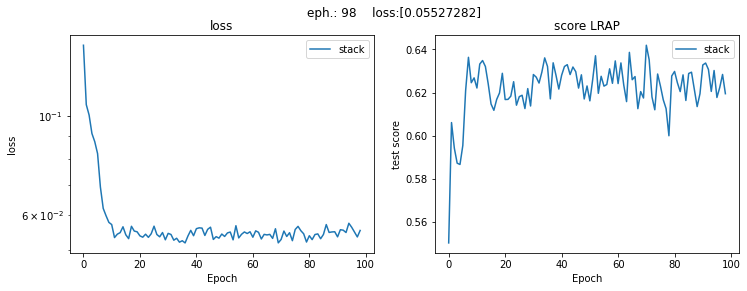

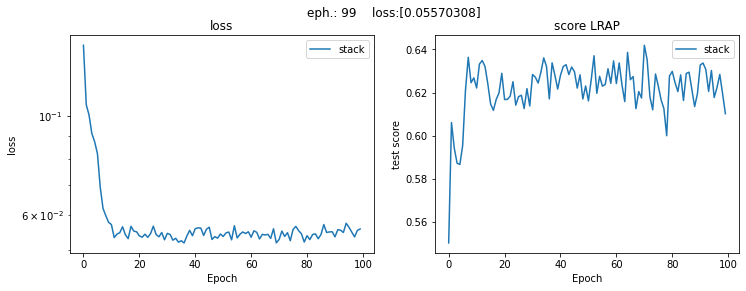

In [148]:
import copy 
from IPython import display
from tqdm.notebook import trange, tqdm

loss_arr = []
test_score_array = [ [] for i in range(num_models)]
max_score = [ 0 for i in range(num_models)]

for iepoch in tqdm(range(EPOCH_NUM),desc='epoch step'):
  inter_loss_arr = []
  for imodel in models_arr:
    imodel.train()
  for idata, ilabels in tqdm(train_loader,desc='train loader'):
    cur_loss_arr = [ [] for i in range(num_models)]
    intI=0
    for imodel,icriterion ,ioptimizer in zip(models_arr,criterion_arr,optimizer_arr):
      cur_loss = train_step(imodel,idata,ilabels,icriterion,ioptimizer,DEVICE)
      cur_loss_arr[intI] = cur_loss
      intI+=1
    inter_loss_arr.append(cur_loss_arr)
  loss_arr.append(np.mean(inter_loss_arr,axis=0))
  cur_test_acc = []
  intI=0

  for imodel,ibest_model, scheduler in zip(models_arr,best_models_arr, scheduler_arr):
    score_cur, test_loss = test_acc(icriterion, test_loader, imodel, DEVICE)
    scheduler.step(test_loss)

    test_score_array[intI].append(score_cur)
    if (score_cur > max_score[intI]) and (update_best_models_Flag):
      max_score[intI]=score_cur
      sd = imodel.state_dict()
      ibest_model.load_state_dict(sd)
      torch.save(sd, PATH+'model_epoch_{:}_{}'.format(EPOCH_NUM, generation))
    intI+=1

  strOUT_1 = 'eph.: {:} '.format(iepoch)
  strOUT_2 = 'loss:' + str(loss_arr[-1])
  strOUT_4 =  'best score. : '+ str(max_score)
  print(strOUT_1)
  print(strOUT_2)
  print(strOUT_4)
    


  # plot figures in epoch
  loss_arr_np = np.array(loss_arr)
  test_score_array_np = np.array(test_score_array)

  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.suptitle(strOUT_1+'   '+strOUT_2)
  plt.title('loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  for idx,inamne in enumerate(ModelNames):
    plt.plot(loss_arr_np[:,idx],label=inamne)
    plt.yscale('log')
  plt.legend()
  plt.subplot(1,2,2)
  plt.title('score LRAP')
  plt.xlabel('Epoch')
  plt.ylabel('test score')
  for idx,inamne in enumerate(ModelNames):
    plt.plot(test_score_array_np[idx],label=inamne)
  plt.legend()

  display.clear_output(wait=True)
  display.display(plt.gcf())

# Результаты

In [149]:
data_mts = np.load(PATH_TO_SAVE + 'MAJOR_test.npz')

In [150]:
majot_test_data = data_mts['data']

In [151]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

majot_test_data = data_mts['data']
majot_test_labels = data_mts['files']
i_num = len(majot_test_labels)
columns = ['recording_id'] + [ 's'+str(inm)  for inm in range(24)]

results = []


for indx in tqdm(range(i_num)):
  idata = torch.Tensor([majot_test_data[indx]]).to(DEVICE)
  output = model(idata).cpu().detach().numpy()
  out_sigm = sigmoid(output)
  results.append(out_sigm)


  0%|          | 0/1992 [00:00<?, ?it/s]

In [152]:
SAVE_RESULTS = 'model_epoch_{:}_{}'.format(EPOCH_NUM, generation) + '.csv'


res_np = np.squeeze(np.array(results))
dict_to_save = {columns[i+1] : res_np[:,i] for i in range(24)} 
dict_to_save['recording_id'] = majot_test_labels
DF_result = pd.DataFrame(dict_to_save,columns=columns)
DF_result.to_csv(PATH + SAVE_RESULTS, index=False)